## Haar-like Features

Determine which Haar features are most relevant for traffic light detection using a RandomForest. Modified script taken from sci-kit image. 

Source: http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html

Save the results to file to use with the Haar Descriptor

In [1]:
from __future__ import division, print_function
from time import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, sys, inspect

from dask import delayed

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature


# Add tl-detector to path so I can import from the project
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir + '/src/') 

@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1], feature_type, feature_coord=feature_coord)

C:\Users\kenan\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from helpers import read_directory_images

# Load in the data
pos_dir = "C:/Users/kenan/Desktop/repos/tl-data/sample-positives/"
neg_dir = "C:/Users/kenan/Desktop/repos/tl-data/negatives/" 

positive_images = list(read_directory_images(pos_dir, extension='.png', n=100))
negative_images = list(read_directory_images(neg_dir, extension='.png', n=100))

# Resize all to 32x64 and convert to grayscale
positive_images = [cv2.resize(im, (32, 64)) for im in positive_images]
negative_images = [cv2.resize(im, (32, 64)) for im in negative_images]
images = np.concatenate((positive_images, negative_images))
images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]

print("Total positive images: {}".format(len(positive_images)))
print("Total negative images: {}".format(len(positive_images)))

Total positive images: 100
Total negative images: 100


In [3]:
# Feature extraction
feature_types = ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y']

# Build a computation graph using dask. This allows using multiple CPUs for
# the computation step. Compute the result using the "processes" dask backend
X = delayed(extract_feature_image(img, feature_types) for img in images)
X = np.array(X.compute(scheduler='processes'))

y = np.array([1] * 100 + [0] * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150, random_state=0, stratify=y)

# Extract all possible features to be able to select the most salient.
feature_coord, feature_type = haar_like_feature_coord(width=32, height=64, feature_type=feature_types)

C:\Users\kenan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Text(0.5,0.98,'The most important features')

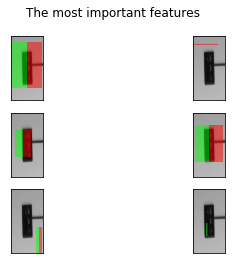

In [4]:
# # Train a random forest classifier and check performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, max_features=100, n_jobs=-1, random_state=0)
clf.fit(X_train, y_train)
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Sort features in order of importance, plot six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = images[41]
    image = draw_haar_like_feature(image, 0, 0, 32, 64, [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('The most important features')

In [5]:
cdf_feature_importances = np.cumsum(clf.feature_importances_[idx_sorted])
cdf_feature_importances /= np.max(cdf_feature_importances)
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.7)
sig_feature_percent = round(sig_feature_count /
                            len(cdf_feature_importances) * 100, 1)
print(('{} features, or {}%, account for 70% of branch points in the random '
       'forest.').format(sig_feature_count, sig_feature_percent))

# Select the most informative features
selected_feature_coord = feature_coord[idx_sorted[:sig_feature_count]]
selected_feature_type = feature_type[idx_sorted[:sig_feature_count]]

825 features, or 0.0%, account for 70% of branch points in the random forest.


### Save output to file

In [7]:
import pickle

with open('haar_out.pkl', 'wb') as f: 
    pickle.dump([selected_feature_coord, selected_feature_type], f)

## SVM Training Results

### Load in Training Data

In [9]:
from helpers import read_directory_images

# Load in the data
pos_dir = "C:/Users/kenan/Desktop/repos/tl-data/positives/"
neg_dir = "C:/Users/kenan/Desktop/repos/tl-data/negatives/" 

positive_images = list(read_directory_images(pos_dir, extension='.png', n=1250))
negative_images = list(read_directory_images(neg_dir, extension='.png', n=1250))

# Resize all to 32x64 and convert to grayscale
positive_images = [cv2.resize(im, (32, 64)) for im in positive_images]
negative_images = [cv2.resize(im, (32, 64)) for im in negative_images]

images = np.concatenate((positive_images, negative_images))
images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]

print("Total positive images: {}".format(len(positive_images)))
print("Total negative images: {}".format(len(negative_images)))

Total positive images: 1250
Total negative images: 1250


### Cross-Train and Evaluate

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

X = delayed(extract_feature_image(img, selected_feature_type, selected_feature_coord) for img in images)
X = np.array(X.compute(scheduler='threads'))
y = np.array([1] * 1250 + [0] * 1250)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

recall = recall_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)

print("Recall: {:.2f}".format(recall))
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))

Recall: 0.88
Accuracy: 0.92
Precision: 0.96
